In [ ]:
import pickle
import torch
import torch.nn as nn
import random
from torch.utils.data import DataLoader
import time
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
class EmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, datalist):
        super(EmbeddingDataset, self).__init__()
        # with open(file, 'rb') as f:
        self.datapoints = datalist

    def __len__(self):
        return len(self.datapoints)

    def __getitem__(self,index):
        return self.datapoints[index]['sentence'],self.datapoints[index]['sentiment']

In [ ]:
with open('embeddings/bert_embedding_classes.pkl', 'rb') as f:
    data = pickle.load(f)
    print(data)
    bert_train_dataset = EmbeddingDataset(data['train'])
    bert_test_dataset = EmbeddingDataset(data['test'])

with open('embeddings/custom_embedding_classes.pkl', 'rb') as f:
    data = pickle.load(f)
    manual_train_dataset = EmbeddingDataset(data['train'])
    manual_test_dataset = EmbeddingDataset(data['test'])


bert_train_dataloader = DataLoader(bert_train_dataset, batch_size = 4,shuffle = True , drop_last = True)
bert_test_dataloader = DataLoader(bert_test_dataset, batch_size = 4,shuffle = True , drop_last = True)
manual_train_dataloader = DataLoader(manual_train_dataset, batch_size = 4,shuffle = True , drop_last = True)
manual_test_dataloader = DataLoader(manual_test_dataset, batch_size = 4,shuffle = True , drop_last = True)

/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


{'train': [{'sentence': tensor([[[-0.3054, -0.3239,  0.3501,  ..., -0.0584,  0.5117,  0.0724],
         [-0.7236, -0.0361,  0.2264,  ...,  0.1423,  0.5426, -0.5037],
         [-0.4372, -0.0729,  0.6901,  ..., -0.3644,  0.3045,  0.8360],
         ...,
         [ 0.5733, -0.2666,  0.6694,  ..., -0.0831,  0.4587, -0.3565],
         [ 0.5859, -0.2359,  0.6860,  ..., -0.0629,  0.4399, -0.4484],
         [ 0.5572, -0.2103,  0.6917,  ..., -0.0714,  0.4275, -0.4898]]]), 'sentiment': tensor([1., 0., 0.])}, {'sentence': tensor([[[-0.0695, -0.3955,  0.3281,  ...,  0.0505,  0.4608,  0.0460],
         [ 0.0362,  0.0041,  0.4694,  ...,  0.2730,  0.3102,  0.3335],
         [-0.1842,  0.2422,  0.4223,  ...,  0.1259,  0.4414,  0.3200],
         ...,
         [ 0.6804, -0.1222,  0.6097,  ..., -0.1843,  0.4623, -0.3165],
         [ 0.7212, -0.0948,  0.6170,  ..., -0.1784,  0.4549, -0.3889],
         [ 0.6820, -0.0725,  0.6002,  ..., -0.1944,  0.4551, -0.4114]]]), 'sentiment': tensor([0., 0., 1.])}, {'sen

In [ ]:
# for data in dataloader:
#     sente,senti = data
#     # print(data)
#     print(sente)
#     print(senti)
#     break
# print(len(dataloader))

In [ ]:
# Architecture modified from https://engineering.purdue.edu/kak/distDLS/DLStudio-2.4.3_CodeOnly.html
class GRUnet(torch.nn.Module):
            def __init__(self, input_size, hidden_size, output_size, num_layers,  batch_size, drop_prob=0.2):
                super(GRUnet, self).__init__()
                self.hidden_size = hidden_size
                self.num_layers = num_layers
                self.gru = nn.GRU(input_size, hidden_size, num_layers,batch_first=True, dropout=drop_prob)
                self.fc = nn.Linear(hidden_size, output_size)
                self.relu = nn.ReLU()
                self.softmax = nn.Softmax(dim=1)
                self.batch_size = batch_size

            def forward(self, x, h):
                out, h = self.gru(x, h)
                out = self.fc(self.relu(out[:,-1]))
                out = self.softmax(out)
                return out, h

            def init_hidden(self):
                weight = next(self.parameters()).data
                #                                     batch_size
                hidden = weight.new(  self.num_layers,    self.batch_size,         self.hidden_size   ).zero_()
                return hidden

In [ ]:
# Architecture modified from https://engineering.purdue.edu/kak/distDLS/DLStudio-2.4.3_CodeOnly.html
class BiGRUnet(torch.nn.Module):
            def __init__(self, input_size, hidden_size, output_size, num_layers,  batch_size, drop_prob=0.2):
                super(BiGRUnet, self).__init__()
                self.hidden_size = hidden_size
                self.num_layers = num_layers
                self.gru = nn.GRU(input_size, hidden_size, num_layers,batch_first=True, dropout=drop_prob, bidirectional=True)
                self.fc = nn.Linear(2*hidden_size, output_size)
                self.relu = nn.ReLU()
                self.softmax = nn.Softmax(dim=1)
                self.batch_size = batch_size

            def forward(self, x, h):
                out, h = self.gru(x, h)
                out = self.fc(self.relu(out[:,-1]))
                out = self.softmax(out)
                return out, h

            def init_hidden(self):
                weight = next(self.parameters()).data
                #                                     batch_size
                hidden = weight.new(  2*self.num_layers,    self.batch_size,         self.hidden_size   ).zero_()
                return hidden

In [ ]:
gru_network_bert = GRUnet(input_size = 768, hidden_size = 512,output_size = 3, num_layers = 2, batch_size = 4)
bi_gru_network_bert = BiGRUnet(input_size = 768, hidden_size = 512,output_size = 3, num_layers = 2, batch_size = 4)

gru_network_manual = GRUnet(input_size = 768, hidden_size = 512,output_size = 3, num_layers = 2, batch_size = 4)
bi_gru_network_manual = BiGRUnet(input_size = 768, hidden_size = 512,output_size = 3, num_layers = 2, batch_size = 4)

In [ ]:
# Code modified from https://engineering.purdue.edu/kak/distDLS/DLStudio-2.4.3_CodeOnly.html
def run_code_for_training_GRU(net, train_dataloader,epochs = 5, learning_rate = 1e-3, momentum = 0.5, display_train_loss=False):
    filename_for_out = "performance_numbers_" + str(epochs) + ".txt"
    FILE = open(filename_for_out, 'w')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    class_weights = torch.tensor([4.15,1.87,5.79],dtype=torch.float)
    class_weights = class_weights.to(device)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights,reduction='mean')

    accum_times = []
    optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, betas = (0.9,0.999))
    start_time = time.perf_counter()
    training_loss_tally = []
    for epoch in range(epochs):
        print("")
        running_loss = 0.0
        for i, data in enumerate(train_dataloader):
            sentence,sentiment = data
            sentence = torch.squeeze(sentence)
            sentence = sentence.to(device)
            sentiment = sentiment.to(device)

            optimizer.zero_grad()
            hidden = net.init_hidden().to(device)

            output, hidden = net(sentence, hidden)
            loss = criterion(output, sentiment)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            if i % 200 == 199:
                avg_loss = running_loss / float(200)
                training_loss_tally.append(avg_loss)
                current_time = time.perf_counter()
                time_elapsed = current_time-start_time
                print("[epoch:%d  iter:%4d  elapsed_time:%4d secs]     loss: %.5f" % (epoch+1,i+1, time_elapsed,avg_loss))
                accum_times.append(current_time-start_time)
                FILE.write("%.3f\n" % avg_loss)
                FILE.flush()
                running_loss = 0.0
    print("Total Training Time: {}".format(str(sum(accum_times))))
    print("\nFinished Training\n")

    if display_train_loss:
        plt.figure(figsize=(10,5))
        plt.title("Training Loss vs. Iterations")
        plt.plot(training_loss_tally)
        plt.xlabel("iterations")
        plt.ylabel("training loss")
        plt.legend(["Plot of loss versus iterations"], fontsize="x-large")
        plt.show()

In [ ]:
# Architecture modified from https://engineering.purdue.edu/kak/distDLS/DLStudio-2.4.3_CodeOnly.html
def run_code_for_testing_GRU(net, dataloader, bi=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = net.to(device)
    confusion_matrix = torch.zeros(3, 3)
    correct = 0
    total = 0
    class_correct = [0] * 3
    class_total = [0] * 3
    D = 2 if bi else 1
    with torch.no_grad():
        for i,data in enumerate(dataloader):

            weight = next(net.parameters()).data
            hidden = weight.new(  D*net.num_layers,    1,         net.hidden_size   ).zero_()
            sentence,sentiment = data
            sentence = sentence[0]
            sentence = sentence.to(device)
            sentiment = sentiment.to(device)
            outputs, hidden = net(sentence,hidden)
            predicted = outputs
            for sentiment,prediction in zip(sentiment,predicted):
                    confusion_matrix[torch.argmax(sentiment)][torch.argmax(prediction)] += 1
                    correct += 1 if torch.argmax(sentiment) == torch.argmax(prediction) else 0
                    total += 1

            if (i%1000 == 999):
                print(i)
    print(confusion_matrix)
    print('Accuracy of the network: %d %%' % (100 * correct / total))
    cm_heatmap = pd.DataFrame(confusion_matrix.numpy(), index = ['positive','neutral','negative'],
                  columns = ['positive','neutral','negative'])
    plt.figure(figsize = (5,4))
    sn.heatmap(cm_heatmap, annot=True, cmap='Blues', fmt='g')
    return confusion_matrix


[epoch:1  iter: 200  elapsed_time:   3 secs]     loss: 3.43473
[epoch:1  iter: 400  elapsed_time:   5 secs]     loss: 3.49212
[epoch:1  iter: 600  elapsed_time:   7 secs]     loss: 3.43866
[epoch:1  iter: 800  elapsed_time:   9 secs]     loss: 3.34831
[epoch:1  iter:1000  elapsed_time:  11 secs]     loss: 3.34220

[epoch:2  iter: 200  elapsed_time:  15 secs]     loss: 3.18686
[epoch:2  iter: 400  elapsed_time:  17 secs]     loss: 3.11089
[epoch:2  iter: 600  elapsed_time:  19 secs]     loss: 3.06671
[epoch:2  iter: 800  elapsed_time:  22 secs]     loss: 3.37713
[epoch:2  iter:1000  elapsed_time:  24 secs]     loss: 3.14605

[epoch:3  iter: 200  elapsed_time:  28 secs]     loss: 2.76832
[epoch:3  iter: 400  elapsed_time:  30 secs]     loss: 2.97307
[epoch:3  iter: 600  elapsed_time:  32 secs]     loss: 2.89281
[epoch:3  iter: 800  elapsed_time:  34 secs]     loss: 2.74036
[epoch:3  iter:1000  elapsed_time:  36 secs]     loss: 2.80577

[epoch:4  iter: 200  elapsed_time:  40 secs]     lo

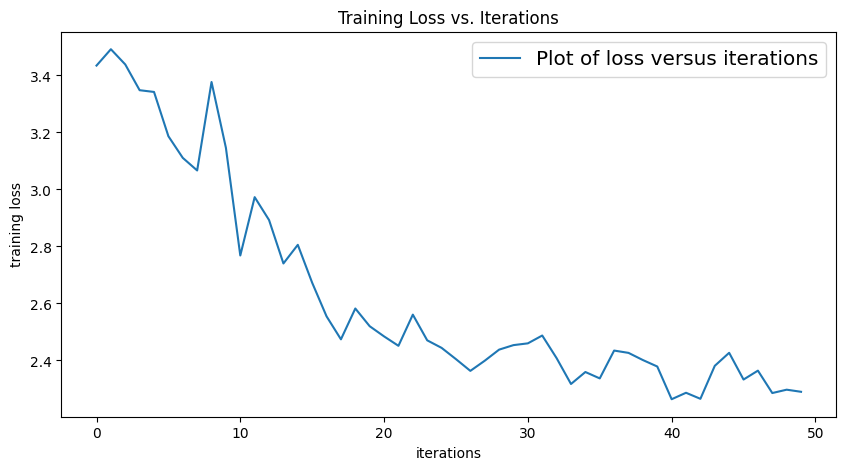

tensor([[ 70.,  16.,   7.],
        [  3., 126.,  29.],
        [  3.,   2.,  36.]])
Accuracy of the network: 79 %


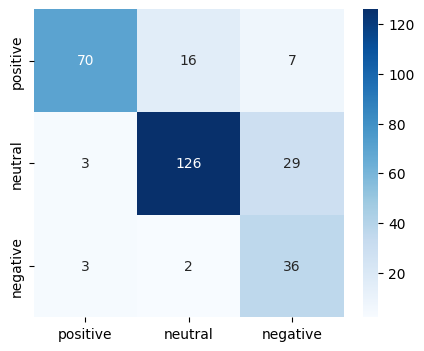

In [ ]:
run_code_for_training_GRU(gru_network_bert, bert_train_dataloader,epochs = 10, learning_rate = 5e-4, momentum = 0.5, display_train_loss=True)
cm = run_code_for_testing_GRU(gru_network_bert, bert_test_dataloader, bi = False)


[epoch:1  iter: 200  elapsed_time:   2 secs]     loss: 3.42673
[epoch:1  iter: 400  elapsed_time:   4 secs]     loss: 3.49929
[epoch:1  iter: 600  elapsed_time:   6 secs]     loss: 3.44364
[epoch:1  iter: 800  elapsed_time:   9 secs]     loss: 3.45167
[epoch:1  iter:1000  elapsed_time:  11 secs]     loss: 3.45217

[epoch:2  iter: 200  elapsed_time:  15 secs]     loss: 3.47147
[epoch:2  iter: 400  elapsed_time:  17 secs]     loss: 3.48069
[epoch:2  iter: 600  elapsed_time:  19 secs]     loss: 3.43529
[epoch:2  iter: 800  elapsed_time:  22 secs]     loss: 3.56432
[epoch:2  iter:1000  elapsed_time:  24 secs]     loss: 3.27422

[epoch:3  iter: 200  elapsed_time:  28 secs]     loss: 3.46011
[epoch:3  iter: 400  elapsed_time:  30 secs]     loss: 3.50761
[epoch:3  iter: 600  elapsed_time:  32 secs]     loss: 3.35260
[epoch:3  iter: 800  elapsed_time:  35 secs]     loss: 3.38185
[epoch:3  iter:1000  elapsed_time:  37 secs]     loss: 3.41089

[epoch:4  iter: 200  elapsed_time:  41 secs]     lo

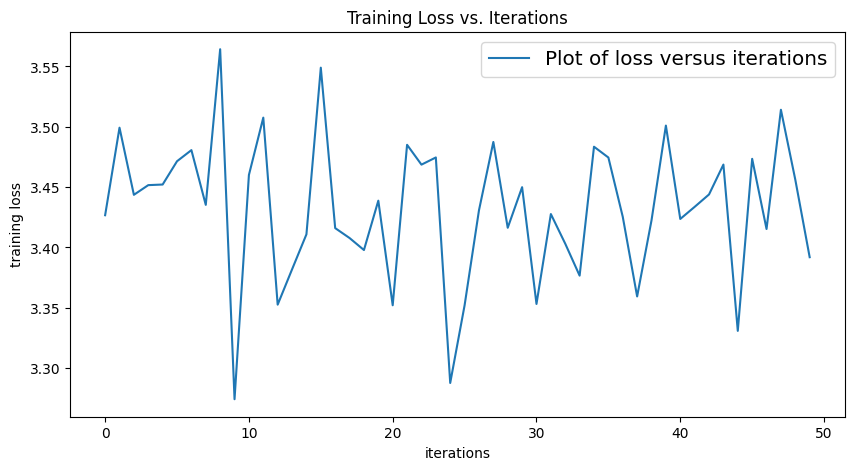

tensor([[102.,   2.,   0.],
        [138.,   3.,   0.],
        [ 47.,   0.,   0.]])
Accuracy of the network: 35 %


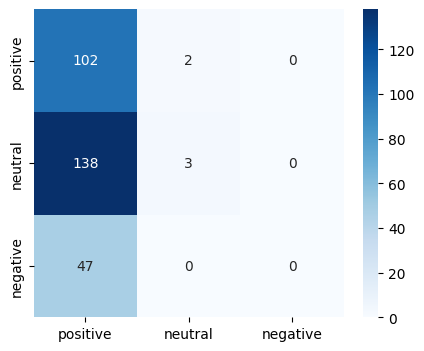

In [ ]:
run_code_for_training_GRU(gru_network_manual, manual_train_dataloader,epochs = 10, learning_rate = 5e-4, momentum = 0.5, display_train_loss=True)
cm = run_code_for_testing_GRU(gru_network_manual, manual_test_dataloader, bi = False)


[epoch:1  iter: 200  elapsed_time:   4 secs]     loss: 3.47611
[epoch:1  iter: 400  elapsed_time:   8 secs]     loss: 3.53555
[epoch:1  iter: 600  elapsed_time:  12 secs]     loss: 3.31161
[epoch:1  iter: 800  elapsed_time:  17 secs]     loss: 3.43288
[epoch:1  iter:1000  elapsed_time:  21 secs]     loss: 3.35142

[epoch:2  iter: 200  elapsed_time:  29 secs]     loss: 3.00513
[epoch:2  iter: 400  elapsed_time:  33 secs]     loss: 3.12549
[epoch:2  iter: 600  elapsed_time:  37 secs]     loss: 2.84514
[epoch:2  iter: 800  elapsed_time:  42 secs]     loss: 3.07980
[epoch:2  iter:1000  elapsed_time:  46 secs]     loss: 2.94211

[epoch:3  iter: 200  elapsed_time:  54 secs]     loss: 2.57988
[epoch:3  iter: 400  elapsed_time:  58 secs]     loss: 2.71056
[epoch:3  iter: 600  elapsed_time:  62 secs]     loss: 2.63491
[epoch:3  iter: 800  elapsed_time:  66 secs]     loss: 2.54641
[epoch:3  iter:1000  elapsed_time:  71 secs]     loss: 2.51754

[epoch:4  iter: 200  elapsed_time:  79 secs]     lo

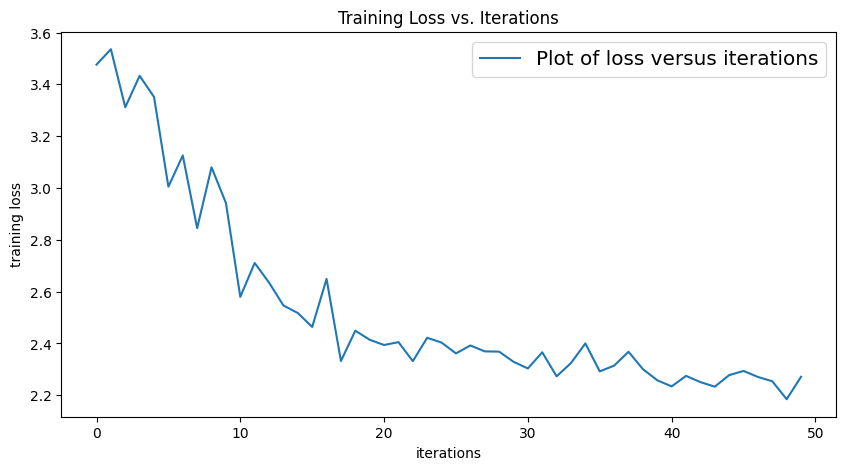

tensor([[67., 10.,  8.],
        [25., 97., 35.],
        [14.,  3., 33.]])
Accuracy of the network: 67 %


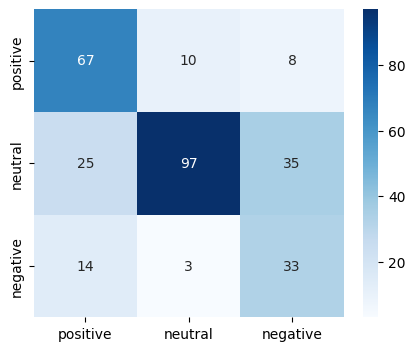

In [ ]:
run_code_for_training_GRU(bi_gru_network_bert, bert_train_dataloader,epochs = 10, learning_rate = 5e-4, momentum = 0.5, display_train_loss=True)
cm = run_code_for_testing_GRU(bi_gru_network_bert, bert_test_dataloader, bi = True)


[epoch:1  iter: 200  elapsed_time:   4 secs]     loss: 3.48181
[epoch:1  iter: 400  elapsed_time:   8 secs]     loss: 3.42403
[epoch:1  iter: 600  elapsed_time:  12 secs]     loss: 3.50517
[epoch:1  iter: 800  elapsed_time:  17 secs]     loss: 3.31987
[epoch:1  iter:1000  elapsed_time:  21 secs]     loss: 3.44416

[epoch:2  iter: 200  elapsed_time:  29 secs]     loss: 3.48698
[epoch:2  iter: 400  elapsed_time:  33 secs]     loss: 3.50498
[epoch:2  iter: 600  elapsed_time:  38 secs]     loss: 3.41598
[epoch:2  iter: 800  elapsed_time:  42 secs]     loss: 3.33375
[epoch:2  iter:1000  elapsed_time:  46 secs]     loss: 3.40428

[epoch:3  iter: 200  elapsed_time:  54 secs]     loss: 3.51970
[epoch:3  iter: 400  elapsed_time:  58 secs]     loss: 3.50142
[epoch:3  iter: 600  elapsed_time:  63 secs]     loss: 3.34501
[epoch:3  iter: 800  elapsed_time:  67 secs]     loss: 3.41919
[epoch:3  iter:1000  elapsed_time:  71 secs]     loss: 3.41008

[epoch:4  iter: 200  elapsed_time:  79 secs]     lo

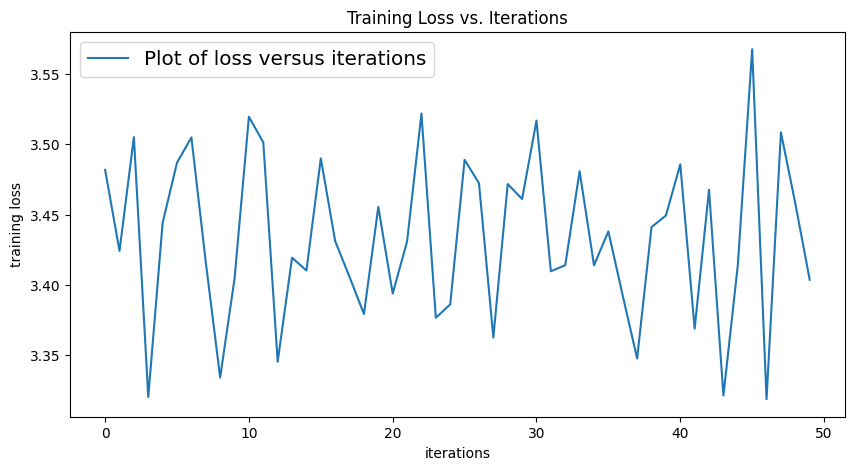

tensor([[ 95.,   0.,   0.],
        [151.,   0.,   0.],
        [ 46.,   0.,   0.]])
Accuracy of the network: 32 %


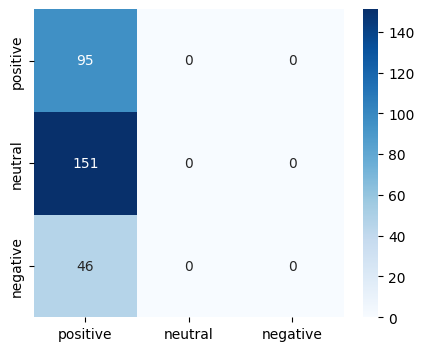

In [ ]:
run_code_for_training_GRU(bi_gru_network_manual, manual_train_dataloader,epochs = 10, learning_rate = 5e-4, momentum = 0.5, display_train_loss=True)
cm = run_code_for_testing_GRU(bi_gru_network_manual, manual_test_dataloader, bi = True)

In [ ]:
torch.save(bi_gru_network_bert.state_dict(), 'models/bi_gru_bert.pt')
torch.save(bi_gru_network_manual.state_dict(), 'models/bi_gru_manual.pt')
torch.save(gru_network_bert.state_dict(), 'models/gru_bert.pt')
torch.save(gru_network_manual.state_dict(), 'models/gru_manual.pt')